# Extraction of cell cycle phases by hierarchical clustering

We try to extract the phases of the cell cycle from our temporal network. We do so by:
1. Computing similarity/distance between every pair of adjacency snapshots
2. Performing hierarchical clustering on these distances

In [1]:
import pathlib
import scipy
import drawing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from clustering import clustering, silhouetting
from clustering.ClusterData import ClusterData
from clustering.HierarchicalClusterSets import HierarchicalClusterSet, HierarchicalClusterSets
from clustering.KMeansClusterSets import KMeansClusterSet, KMeansClusterSets
from temporal_networks.TemporalNetwork import TemporalNetwork
from ODEs.ODEsSolutions import ODEsSolutions
from ODEs import ODEs

sb.set_context("paper")

## Declare parameters to use throughout

In [2]:
distance_metric = 'euclidean'
# Determines which distance function to use when calculating distances between a temporal network's
# adjacency matrices/snapshots. Options are (ToDo)

cluster_method = 'ward'
# Determines which method to use when generating clusters. Options are 'k_means', 'ward', 'median', 'centroid',
# 'weighted', 'average', 'complete' and 'single'.
# The options 'ward', 'median', 'centroid', 'weighted', 'average', 'complete' and 'single' all use hierarchical
# clustering. Specifically, they use the method scipy.cluster.hierarchy.linkage - for more details, see the 
# documentation for that method.
# If instead cluster_method is 'k_means' then sklearn.cluster.KMeans.fit_predict is used.

cluster_limit_type = 'distance'
# Determines how to decide how many clusters to use. Options are 'maxclust_monocrit', 'monocrit', 'maxclust',
# 'distance' and 'inconsistent'. If cluster_method is 'k_means' then cluster_limit_type MUST be 'maxclust'.
# If cluster_method is NOT 'k_means', see documentation for scipy.cluster.hierarchy.fcluster for more details.

cluster_limit_single = 6
# When plotting over a SINGLE set of clusters, this corresponds to cluster_limit_type above. 
# e.g. if cluster_limit_type is 'distance' then clustering will stop when the distance between clusters is at least 
# cluster_limit_single.

cluster_limit_range = range(5, 15)
# When plotting over a RANGE of clusters, these correspond to cluster_limit_type above.
# e.g. if cluster_limit_type is 'distance' then the ith set of clusters will be formed by stopping clustering when 
# the distance between clusters is at least cluster_limit_range[i].

temporal_network_filepath = "data/tedges_combined_weighted_binary_method_percentage_minmax_p_0.5_clean2.tedges"
# Path to the file representing the temporal network.

output_directory = None
# Directory into which any images will be output. Set to None if no output is required.

## Optional parameters
Set to `None` if not applicable

In [3]:
events = [
    (5, 'START', 'dashed'),
    (33, 'bud', 'solid'),
    (36, 'ori', 'solid'),
    (70, 'E3', 'dashed'),
    (84, 'spn', 'solid'),
    (100, 'mass', 'solid')]
# A list of triples (time, name, line_style). Some plots/diagrams will be annotated with these events. Use if there
# are events known ahead of time to be important - e.g. in a cell cycle, the point at which a cell starts dividing. 
# For line_style options, see documentation for matplotlib.lines.Line2D.set_linestyle.

phases = [
    (0, 35, 'G1'),
    (35, 70, 'S'),
    (70, 78, 'G2'),
    (78, 100, 'M')]
# A list of triples (start_time, end_time, name). Some plots/diagrams will be annotated with these phases. Use if 
# there are phases known ahead of time to be important - e.g. the time period in which a cell is in mitosis.

# ode_filepath = 'data/bychen04_xpp.ode'
ode_filepath = None
# Filepath to a system of ODEs to be solved. Some variables (see below) from this system will be plotted alongside
# plots of cluster data.

variables = ['cln3', 'cln2', 'clb5', 'clb2','mass']
# Determines which variables from the system of ODEs above will be plotted. Case sensitive.

variables_labels_xvals = [10, 90, 95, 55, 30]
# Determines where to place a variable's label when plotting. That is, the line corresponding to variables[i] will
# be labelled at point variables_labels_positions[i] along the x-axis.


## Load our cell cycle temporal network

In [4]:
temporal_network = TemporalNetwork.from_file(temporal_network_filepath, "\s*\t\s*")
temporal_network_name = pathlib.Path(temporal_network_filepath).stem
times = np.array(temporal_network.time_points(starting_at_zero=True))

### Solve system of ODEs (if applicable)

In [5]:
if ode_filepath is not None:
    true_times = np.array(temporal_network.time_points(starting_at_zero=False))
    start_time = int(true_times[0])
    end_time = 1 + int(true_times[-1])
    odes_solutions = ODEsSolutions(ode_filepath, start_time, end_time)
else:
    odes_solutions = None

## Plot relative minima of mass
ToDo: why do we do this?

In [6]:
if ode_filepath is not None:
    fig, ax = plt.subplots()

    # Find local minima
    mass_series = odes_solutions.series('mass')
    mass_relative_minima_times = scipy.signal.argrelextrema(mass_series, np.less)
    mass_relative_minima = mass_series[mass_relative_minima_times]

    ax.plot(times, mass_series, 'o-')
    ax.plot(times[mass_relative_minima_times], mass_relative_minima, 'ro')

    plt.show()

## Compute single set of clusters

In [7]:
# Compute clusters
cluster_data = ClusterData.from_temporal_network(temporal_network, cluster_method, distance_metric)
if cluster_method != 'k_means':
    cluster_set = HierarchicalClusterSet(
        cluster_data.linkage,
        cluster_data.distance_matrix,
        cluster_limit_type,
        cluster_limit_single)
else:
    cluster_set = KMeansClusterSet(
        cluster_data.flat_snapshots,
        cluster_limit_type,
        cluster_limit_single,
        distance_metric)

## Complete plot for single set of clusters

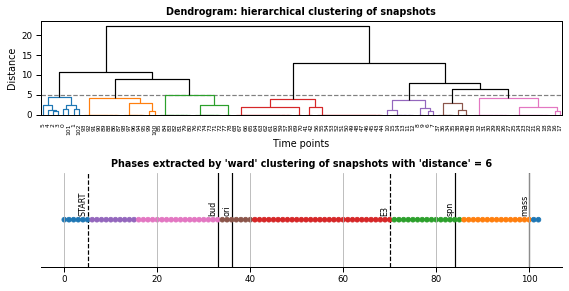

In [8]:
drawing.utils.configure_colour_map()
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 6))

# On 2nd axes, plot scatter graph of clusters.
title = f"Phases extracted by '{cluster_method}' clustering of snapshots with '{cluster_limit_type}' = {cluster_limit_single}"
clustering.plot_scatter_of_clusters(cluster_set.clusters, times, ax=ax2, title=title)

# Overlay events
sb.set_palette('Dark2', n_colors=8)
ODEs.plot_events(events, ax=ax2, y_pos=0.005, text_x_offset=1)

# On 1st axes, plot dendrogram (if not using k-means clustering)
if cluster_method != 'k_means':
    title = 'Dendrogram: hierarchical clustering of snapshots'
    clustering.plot_dendrogram_from_clusters(cluster_data.linkage, cluster_set.size, ax=ax1, title=title)
else:
    fig.delaxes(ax1)

# On 3rd axes, plot ODE solutions and phases (if applicable)
if ode_filepath is not None:
    ODEs.plot_concentrations(odes_solutions, variables, times, ax=ax3, norm=True, labels_xvals=variables_labels_xvals)
    ODEs.plot_phases(phases, ax=ax3, y_pos=1.1)
    # Tidy up formatting
    ax2.get_shared_x_axes().join(ax2, ax3)
    ax3.autoscale()
else:
    fig.delaxes(ax3)

fig.tight_layout()

# Save plot
if output_directory is not None:
    filename = f"phases_from_clustering_{cluster_limit_type}_{cluster_limit_single}_method_{cluster_method}"
    filename = f"{output_directory}{filename}_{temporal_network_name}"
    plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
    plt.savefig(f"{filename}.pdf", dpi=250, bbox_inches="tight")

plt.show()


## Plot cluster and silhouette data over a range of clusters

Start by computing silhouette samples/scores across clusters

In [9]:
if cluster_method != 'k_means':
    cluster_sets = HierarchicalClusterSets(
        cluster_data.linkage,
        cluster_data.distance_matrix,
        cluster_limit_type,
        cluster_limit_range)
else:
    cluster_sets = KMeansClusterSets(
        cluster_data.flat_snapshots,
        cluster_limit_type,
        cluster_limit_range,
        distance_metric)

Plot silhouette scores across range of clusters

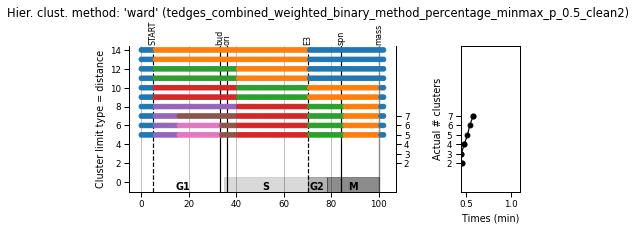

In [10]:
title = f"Hier. clust. method: '{cluster_method}' ({temporal_network_name})"
fig, (ax1, ax2) = silhouetting.plot_average_silhouettes_and_clusters(cluster_sets, times, title)
ax1.set_ylabel(f'Cluster limit type = {cluster_limit_type}')
ax2.set_xlabel("Times (min)")

ODEs.plot_events(events, ax=ax1)
ODEs.plot_phases(phases, ax=ax1, y_pos=-1, ymax=0.1)

if output_directory is not None:
    filename = f"{output_directory}phase_clusters_all_method_{cluster_method}_{temporal_network_name}"
    plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
    plt.savefig(f"{filename}.pdf", dpi=250, bbox_inches="tight")


Plot silhouette samples across range of clusters

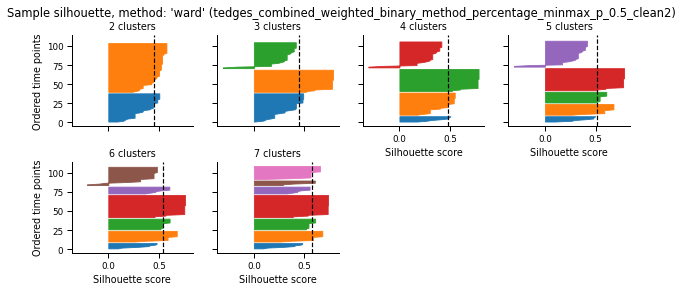

In [11]:
fig, axs = silhouetting.plot_silhouettes_samples(cluster_sets, columns=4)
fig.suptitle(f"Sample silhouette, method: '{cluster_method}' ({temporal_network_name})")
plt.subplots_adjust(hspace=0.4)
plt.show()

if output_directory is not None:
    filename = f"{output_directory}phase_clusters_silhouette_sample_method_{cluster_method}_{temporal_network_name}"
    plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
    plt.savefig(f"{filename}.pdf", dpi=250, bbox_inches="tight")